# Deep Learning
## HW2 - Problem 3

Name: Amin Robatian

Student Number: 400301075

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Lambda
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import pandas as pd
import random
from math import floor
import string
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(85)
random.seed(85)
np.random.seed(85)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DL HW2/

Mounted at /content/drive
/content/drive/MyDrive/DL HW2


# Part (A)

In [3]:
df_train = pd.read_csv("Q3_train.csv")
df_test = pd.read_csv("Q3_test.csv")

images_train = np.array(df_train.iloc[:, 1:])
labels_train = np.array(df_train.iloc[:, 0])

images_test = np.array(df_test.iloc[:,1:])
labels_test = np.array(df_test.iloc[:,0])

labels_class = list(string.ascii_uppercase)

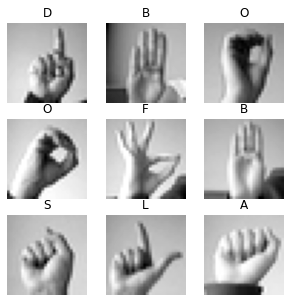

In [4]:
figure = plt.figure(figsize=(5, 5))
rows, cols = 3, 3
i = 0
for j in range(9):
  i += 1
  sample_idx = torch.randint(len(labels_train), size=(1,)).item()
  img = images_train[sample_idx,:].reshape(28,28)
  label = labels_class[labels_train[sample_idx]]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")  
    
plt.show()

# Part (B) - SGD v.s. ADAM

In [5]:
images_train = np.array(df_train.iloc[:floor(0.85 * len(df_train)),1:])
images_train = images_train / 255
labels_train = np.array(df_train.iloc[:floor(0.85 * len(df_train)),0])

images_validation = np.array(df_train.iloc[floor(0.85 * len(df_train)):,1:])
images_validation = images_validation / 255
labels_validation = np.array(df_train.iloc[floor(0.85 * len(df_train)):,0])

images_test = np.array(df_test.iloc[:,1:])
images_test = images_test / 255
labels_test = np.array(df_test.iloc[:,0])

print(f"{len(labels_train):,} samples for Training and {len(labels_validation):,} samples for Validation")

lb = LabelBinarizer()
labels_train = lb.fit_transform(labels_train) # Changing labels to one-hot encoded vector  
labels_validation = lb.transform(labels_validation) # Changing labels to one-hot encoded vector
labels_test = lb.transform(labels_test) # Changing labels to one-hot encoded vector

23,336 samples for Training and 4,119 samples for Validation


In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 24)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
sgd_learning_rate = 1e-2
adam_learning_rate = 3e-4
batch_size = 32
epochs = 20

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X_train, y_train, transform=None, target_transform=None):
      self.transform = transform
      self.target_transform = target_transform
      # need to convert float64 to float32 else 
      # will get the following error
      # RuntimeError: expected scalar type Double but found Float
      self.X = torch.from_numpy(X_train.astype(np.float32))
      # need to convert float64 to Long else 
      # will get the following error
      # RuntimeError: expected scalar type Long but found Float
      self.y = torch.from_numpy(y_train).type(torch.float)
      self.len = self.X.shape[0]
  
    def __getitem__(self, index):
      feature = self.X[index]
      if self.transform:
        feature = self.transform(self.X[index])
      label = self.y[index]
      if self.target_transform:
        label = self.target_transform(self.y[index])
      return feature, label  
    def __len__(self):
      return self.len

In [9]:
target_transform = Lambda(lambda y: torch.zeros(25, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
training_data = CustomDataset(images_train, labels_train)
validation_data = CustomDataset(images_validation, labels_validation)
test_data = CustomDataset(images_test, labels_test)

In [10]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [11]:
def TrainDataSet_Accuracy(dataloader, model, loss_fn):
    size = floor(len(dataloader.dataset) / batch_size) * batch_size
    num_batches = floor(len(dataloader.dataset) / batch_size)
    train_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            if len(X) < batch_size:
              break
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            #
            for i in range(batch_size):
              v1 = pred[i]
              v2 = y[i]
              if torch.argmax(v1) == torch.argmax(v2):
                correct += 1
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size
    print(f"Train Dataset: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    return train_loss

In [12]:
def TestDataSet_Accuracy(dataloader, model, loss_fn):
    size = floor(len(dataloader.dataset) / batch_size) * batch_size
    num_batches = floor(len(dataloader.dataset) / batch_size)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            if len(X) < batch_size:
              break
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #
            for i in range(batch_size):
              v1 = pred[i]
              v2 = y[i]
              if torch.argmax(v1) == torch.argmax(v2):
                correct += 1
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Dataset: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

With SGD ALgorithm:

In [14]:
# creating an instance of our model
model_sgd = NeuralNetwork().to(device)
print(model_sgd)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=24, bias=True)
  )
)


In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sgd.parameters(), lr=sgd_learning_rate, momentum=0.9)
train_loss_SGD = np.zeros(epochs)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_sgd.train()
    train_loop(train_dataloader, model_sgd, loss_fn, optimizer)
    model_sgd.eval()
    train_loss_SGD[t] = TrainDataSet_Accuracy(train_dataloader, model_sgd, loss_fn)
    TestDataSet_Accuracy(test_dataloader, model_sgd, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Train Dataset: 
 Accuracy: 44.7%, Avg loss: 1.682990 

Test Dataset: 
 Accuracy: 41.5%, Avg loss: 1.799846 

Epoch 2
-------------------------------
Train Dataset: 
 Accuracy: 72.5%, Avg loss: 0.783350 

Test Dataset: 
 Accuracy: 61.3%, Avg loss: 1.136679 

Epoch 3
-------------------------------
Train Dataset: 
 Accuracy: 82.4%, Avg loss: 0.479348 

Test Dataset: 
 Accuracy: 67.9%, Avg loss: 1.018764 

Epoch 4
-------------------------------
Train Dataset: 
 Accuracy: 91.9%, Avg loss: 0.243865 

Test Dataset: 
 Accuracy: 72.0%, Avg loss: 1.091692 

Epoch 5
-------------------------------
Train Dataset: 
 Accuracy: 94.6%, Avg loss: 0.154186 

Test Dataset: 
 Accuracy: 75.8%, Avg loss: 1.053317 

Epoch 6
-------------------------------
Train Dataset: 
 Accuracy: 96.6%, Avg loss: 0.111496 

Test Dataset: 
 Accuracy: 75.7%, Avg loss: 1.029658 

Epoch 7
-------------------------------
Train Dataset: 
 Accuracy: 90.8%, Avg loss: 0.258089 

Test Datase

With ADAM Algorithm:

In [16]:
# creating an instance of our model
model_adam = NeuralNetwork().to(device)
print(model_adam)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=24, bias=True)
  )
)


In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_adam.parameters(), lr=adam_learning_rate)
train_loss_Adam = np.zeros(epochs)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_adam.train()
    train_loop(train_dataloader, model_adam, loss_fn, optimizer)
    model_adam.eval()
    train_loss_Adam[t] = TrainDataSet_Accuracy(train_dataloader, model_adam, loss_fn)
    TestDataSet_Accuracy(test_dataloader, model_adam, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Train Dataset: 
 Accuracy: 50.0%, Avg loss: 1.427770 

Test Dataset: 
 Accuracy: 48.0%, Avg loss: 1.597324 

Epoch 2
-------------------------------
Train Dataset: 
 Accuracy: 68.9%, Avg loss: 0.869311 

Test Dataset: 
 Accuracy: 59.2%, Avg loss: 1.259720 

Epoch 3
-------------------------------
Train Dataset: 
 Accuracy: 84.3%, Avg loss: 0.447843 

Test Dataset: 
 Accuracy: 66.4%, Avg loss: 1.065156 

Epoch 4
-------------------------------
Train Dataset: 
 Accuracy: 91.6%, Avg loss: 0.251487 

Test Dataset: 
 Accuracy: 72.6%, Avg loss: 0.947676 

Epoch 5
-------------------------------
Train Dataset: 
 Accuracy: 92.5%, Avg loss: 0.225880 

Test Dataset: 
 Accuracy: 72.2%, Avg loss: 1.093347 

Epoch 6
-------------------------------
Train Dataset: 
 Accuracy: 96.8%, Avg loss: 0.108777 

Test Dataset: 
 Accuracy: 75.0%, Avg loss: 1.001241 

Epoch 7
-------------------------------
Train Dataset: 
 Accuracy: 98.9%, Avg loss: 0.051463 

Test Datase

Comparison of performance and capabilities of two optimization algorithms 1 and 2 for network training:

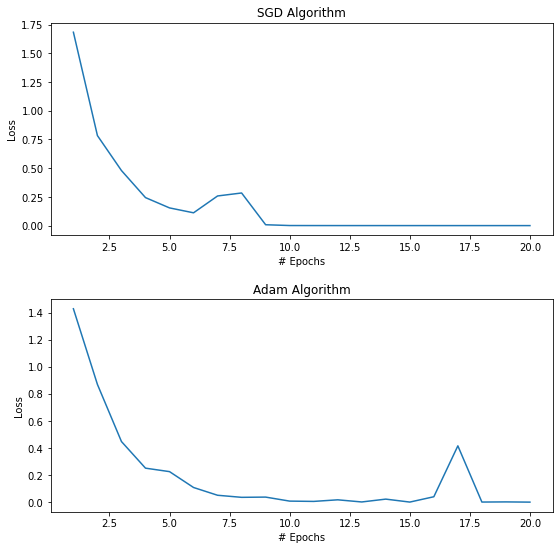

In [18]:
x = np.arange(1,epochs + 1)

figure = plt.figure(figsize=(9, 9))
rows, cols = 2, 1

figure.add_subplot(rows, cols, 1)
plt.plot(x, train_loss_SGD)
plt.title("SGD Algorithm")
plt.xlabel("# Epochs")
plt.ylabel("Loss")

figure.add_subplot(rows, cols, 2)
plt.plot(x, train_loss_Adam)
plt.title("Adam Algorithm")
plt.xlabel("# Epochs")
plt.ylabel("Loss")

plt.subplots_adjust(hspace=0.3)   
plt.show()

**Results :** 

SGD: SGD subtracts the gradient multiplied by the learning rate from the weights.

ADAM:  The idea behind Adam optimizer is to utilize the momentum concept from “SGD with momentum” and adaptive learning rate from “Ada delta”.

SGD v.s. ADAM:

In solving this problem, the SGD algorithm performs better. It is more robust and also it reaches a better accuracy. 

It should be noted that every method has a weakness, so there is often a value to using more than one method. 
Here’s a blog post reviewing an article claiming SGD is a better generalized adapter than ADAM: https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/

# Part (C) - Dropout Regularization

In [19]:
class NeuralNetwork_Dropout(nn.Module):
    def __init__(self):
        super(NeuralNetwork_Dropout, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 24)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [20]:
# creating an instance of our model
model_dropout = NeuralNetwork_Dropout().to(device)
print(model_dropout)

NeuralNetwork_Dropout(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=1024, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=24, bias=True)
  )
)


In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_dropout.parameters(), lr=sgd_learning_rate, momentum=0.9)
train_loss_SGD = np.zeros(epochs)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_dropout.train()
    train_loop(train_dataloader, model_dropout, loss_fn, optimizer)
    model_dropout.eval()
    train_loss_SGD[t] = TrainDataSet_Accuracy(train_dataloader, model_dropout, loss_fn)
    TestDataSet_Accuracy(test_dataloader, model_dropout, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Train Dataset: 
 Accuracy: 40.7%, Avg loss: 1.769091 

Test Dataset: 
 Accuracy: 37.4%, Avg loss: 1.951920 

Epoch 2
-------------------------------
Train Dataset: 
 Accuracy: 52.6%, Avg loss: 1.328397 

Test Dataset: 
 Accuracy: 40.4%, Avg loss: 1.729520 

Epoch 3
-------------------------------
Train Dataset: 
 Accuracy: 69.9%, Avg loss: 0.809160 

Test Dataset: 
 Accuracy: 55.4%, Avg loss: 1.299206 

Epoch 4
-------------------------------
Train Dataset: 
 Accuracy: 64.9%, Avg loss: 1.023293 

Test Dataset: 
 Accuracy: 51.9%, Avg loss: 1.790099 

Epoch 5
-------------------------------
Train Dataset: 
 Accuracy: 85.4%, Avg loss: 0.422046 

Test Dataset: 
 Accuracy: 66.5%, Avg loss: 1.052152 

Epoch 6
-------------------------------
Train Dataset: 
 Accuracy: 89.9%, Avg loss: 0.258930 

Test Dataset: 
 Accuracy: 74.1%, Avg loss: 0.949718 

Epoch 7
-------------------------------
Train Dataset: 
 Accuracy: 92.0%, Avg loss: 0.223287 

Test Datase

**Resluts:**

As we know, Drop-Out technique is one of the regularization techniques that increases the generalization capability of the network.

By comparing the results of this section and the previous section, it can be seen that using this technique, we were able to improve the network error on the test data.

# Part (D) - The Best Network

The best network we reached is the following network trained using SGD algorithm:

In [22]:
print(model_dropout)

NeuralNetwork_Dropout(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=1024, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=24, bias=True)
  )
)


In [23]:
TestDataSet_Accuracy(test_dataloader, model_dropout, loss_fn)

Test Dataset: 
 Accuracy: 82.1%, Avg loss: 1.030833 



# Part (F) - Network testing using three sample images

In [24]:
from PIL import Image
import string
import cv2
labels_class = list(string.ascii_uppercase)
labels_class = labels_class[0:9] + labels_class[10:25]

model_dropout.eval()

NeuralNetwork_Dropout(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=1024, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=24, bias=True)
  )
)

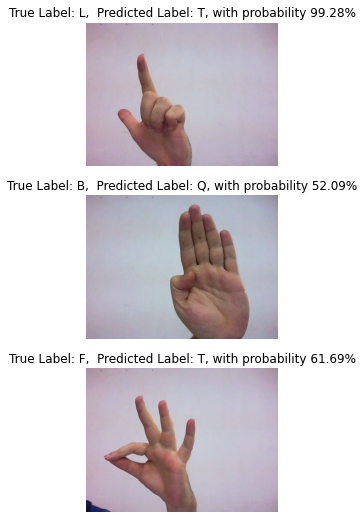

In [25]:
WIDTH = 28
HEIGHT = 28

labels_true = ['L', 'B', 'F']

figure = plt.figure(figsize=(9, 9))
image_list = ['first.jpg', 'second.jpg', 'third.jpg']
rows, cols = 3, 1
i = 0
for j in range(3):
  i += 1
  # Image Processing
  img = Image.open(image_list[j])
  resized_img = img.resize((WIDTH, HEIGHT))
  resized_img = resized_img.convert("L")
  resized_img.save("resized_photo.jpg")
  img_cv = cv2.imread('resized_photo.jpg', cv2.IMREAD_UNCHANGED)
  img_flatten = img_cv.reshape(1, 784)
  # Prediction
  feature_tensor = torch.from_numpy(img_flatten.astype(np.float32))
  feature_tensor = torch.reshape(feature_tensor, (1, 28*28))
  feature_tensor = feature_tensor / 255
  feature_tensor = feature_tensor.to(device)
  with torch.no_grad():
    pred = model_dropout(feature_tensor)
    pred = torch.softmax(pred, dim=1)
  max_index = torch.argmax(pred)
  max_value = pred[0, max_index]
  #
  figure.add_subplot(rows, cols, i)
  label_true = labels_true[j]
  label_predicted = labels_class[max_index]
  plt.title(f"True Label: {label_true},  Predicted Label: {label_predicted}, with probability {(100 * max_value):.2f}%")
  #plt.title(f"True Label: {label_true},  Predicted Label: {label_predicted}")
  plt.axis("off")
  plt.imshow(img) 
  
plt.show()